## Step 1: Importing Libraries

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow_hub as hub

## Step 2: Dataset Inclusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 3: Loading Pretrained Models

In [ ]:
model_path = "/content/drive/My Drive/Yoga/Yoga_Pose_vgg16.h5"
model_vgg = load_model(model_path)

In [ ]:
# Load PoseNet model from TensorFlow Hub
posenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

## Step 4: Extracting Pose Keypoints with PoseNet

In [ ]:
# Define function to get pose keypoints
def get_pose_keypoints(image_path):
    image = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"Error: Could not read the image at {image_path}")

    image = tf.image.resize(image, (192, 192))
    image = np.array(image.numpy(), dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)
    image = tf.convert_to_tensor(image, dtype=tf.int32)

    # Run PoseNet model
    outputs = posenet.signatures["serving_default"](input=image)
    keypoints = outputs["output_0"].numpy()[0, 0, :, :2]

    return keypoints.flatten()

##  Step 5: Generating Reference Keypoints for Yoga Poses

In [ ]:
# Function to extract and store reference keypoints
def generate_reference_keypoints(dataset_path):
    reference_poses = {}

    for pose_name in os.listdir(dataset_path):
        pose_dir = os.path.join(dataset_path, pose_name)
        if os.path.isdir(pose_dir):
            keypoints_list = []
            for image_name in os.listdir(pose_dir):
                image_path = os.path.join(pose_dir, image_name)
                try:
                    keypoints = get_pose_keypoints(image_path)
                    keypoints_list.append(keypoints)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

            if keypoints_list:
                reference_poses[pose_name] = np.mean(keypoints_list, axis=0)

    return reference_poses

In [ ]:
# Update reference poses dynamically
reference_poses = generate_reference_keypoints("/content/drive/My Drive/Yoga/DATASET/TRAIN")

## Step 6: Validating Yoga Poses Using PoseNet

In [ ]:
# Function to integrate PoseNet validation & compute accuracy
def validate_pose(image_path):
    keypoints = get_pose_keypoints(image_path)
    min_distance = float('inf')
    best_match = None

    for pose_name, ref_keypoints in reference_poses.items():
        distance = np.linalg.norm(keypoints - ref_keypoints)  # Compute similarity
        if distance < min_distance:
            min_distance = distance
            best_match = pose_name

    threshold = 10.0  # Adjust based on accuracy needs
    pose_validity = "Valid" if min_distance < threshold else "Invalid"

    # Compute PoseNet accuracy (lower distance = higher accuracy)
    posenet_accuracy = max(0, 100 - (min_distance * 5))  # Adjust scaling factor if needed
    posenet_accuracy = round(posenet_accuracy, 2)

    return best_match, pose_validity, posenet_accuracy

## Step 7: Visualizing Pose Classification Results

In [ ]:
# Function to visualize the results
def display_results(image_path, posenet_pose, pose_validity, posenet_accuracy):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"PoseNet Prediction: {posenet_pose} ({pose_validity}, {posenet_accuracy:.2f}%)")
    plt.show()


## Step 8: Testing

In [ ]:
# Test with an image
# test_image = "/content/drive/My Drive/Yoga/DATASET/TEST/Goddess/00000036.jpg"
test_image = "/content/drive/My Drive/abc.jpg"
posenet_pose, pose_validity, posenet_accuracy = validate_pose(test_image)

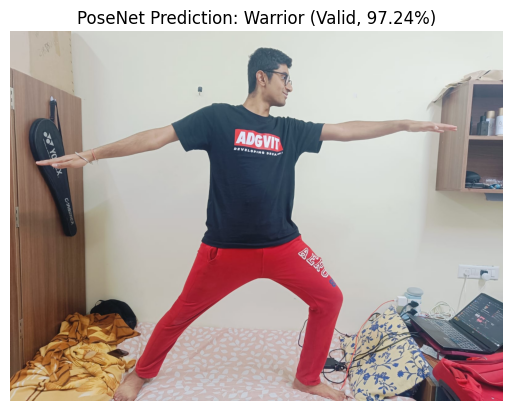

In [ ]:
display_results(test_image, posenet_pose, pose_validity, posenet_accuracy)